In [ ]:
import pydicom
import matplotlib.pyplot as plt
import os
import numpy as np
file_dir = os.path.dirname(os.getcwd()) # the directory that options.py resides in

print(file_dir)
root_dir = file_dir.split("/code")[0]
dataset_dir = root_dir+"/dataset"
dataset_dir

In [ ]:
def MaxMinNormalizer(data):
    data_max = np.max(data)
    data_min = np.min(data)
    #print(data_max, data_min)
    data_normalize = (data - data_min) / (data_max - data_min)
    print(f"data max: {data_max}, data min: {data_min}")
    return data_normalize

def window_pixel_array(ds):
    pixel_array = ds.pixel_array
    if 'WindowWidth' in ds and 'WindowCenter' in ds:
        #print("defined")
        window_width = ds.WindowWidth
        window_center = ds.WindowCenter
        if isinstance(window_width, pydicom.valuerep.DSfloat):
            window_width = [window_width]
        if isinstance(window_center, pydicom.valuerep.DSfloat):
            window_center = [window_center]
    
        windowed_image = (pixel_array - (window_center[0] - window_width[0] / 2)) / window_width[0] * 255.0
        windowed_image = np.clip(windowed_image, 0, 255).astype(np.uint16)
    else:
        windowed_image = pixel_array
    
    return windowed_image

def loadPETValue(directory):
    data = []
    for file_name in sorted(os.listdir(directory)):
        full_file_name = os.path.join(directory, file_name)
        ds = pydicom.dcmread(full_file_name)
        pixel_array = ds.pixel_array
        data.append(pixel_array)    
    data = np.array(data)
    return data

def calScaleFactor(data):
    non_zero_elements = data[data > 1]
    # print(data.mean(), non_zero_elements.mean())
    mean_non_zero = non_zero_elements.mean()
    return mean_non_zero


In [161]:
def viewData(data):
    
    flatten_data = data.flatten()
    flatten_data = flatten_data[flatten_data < 2000]
    counts, bins, patches = plt.hist(flatten_data, bins=10, edgecolor='black', alpha=0.7)

    percentages = 100 * counts / len(flatten_data)

    for i in range(len(patches)):
        plt.text(bins[i] + (bins[i+1] - bins[i])/2, counts[i], f'{percentages[i]:.2f}%', 
                ha='center', va='bottom')

    plt.title('Histogram with Percentage')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.show()

    threshold = np.percentile(flatten_data, 99.99)
    return threshold

def calSUV(ds):
    patient_weight = float(ds.PatientWeight) * 1000  # Convert to grams
    # print(ds.RadiopharmaceuticalInformationSequence)
    injected_dose = float(ds.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)  # Total injected dose
    half_life = float(ds.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife)  # Half-life of the radionuclide

    # Time data extraction
    acquisition_time = ds.AcquisitionTime.split('.')[0]  # Scan time
    injection_time = ds.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime.split('.')[0]    
    
    # Convert times to seconds
    acquisition_time_seconds = int(acquisition_time[:2]) * 3600 + int(acquisition_time[2:4]) * 60 + int(acquisition_time[4:])
    injection_time_seconds = int(injection_time[:2]) * 3600 + int(injection_time[2:4]) * 60 + int(injection_time[4:])
    delta_t = acquisition_time_seconds - injection_time_seconds  # Delay between injection and sca

    # Get the pixel array and rescale
    pixel_array = ds.pixel_array
    rescale_slope = float(ds.RescaleSlope)
    rescale_intercept = float(ds.RescaleIntercept)
    activity_concentration = pixel_array * rescale_slope + rescale_intercept

    # Calculate the decay factor
    decay_factor = 2 ** (-delta_t / half_life)

    # Calculate SUV
    # print(f"delta_t: {delta_t}, max activity_concentration: {np.max(activity_concentration)}, patient_weight: {patient_weight}, injected_dose: {injected_dose}, decay_factor: {decay_factor}")
    suv = (activity_concentration * patient_weight) / (injected_dose * decay_factor)
    return suv

def normSUV(suv, threshold = 6):
    suv = np.clip(suv, 0, 6)
    return suv

def calSUVVolume(directory):
    data = []
    for file_name in sorted(os.listdir(directory)):
        full_file_name = os.path.join(directory, file_name)
        ds = pydicom.dcmread(full_file_name)
        suv = calSUV(ds)
        data.append(suv)
    data = np.array(data)
    return data

def suvToImage(suv):
    image = suv * 255.0 / 6.0
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.colorbar(label='SUV')
    plt.title('SUV Image')
    plt.axis('off')
    plt.show()


(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: '20220221'
(0008, 0013) Instance Creation Time              TM: '182827.310400'
(0008, 0016) SOP Class UID                       UI: Positron Emission Tomography Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.156.112605.159303470343965.220224102511.4.6352.66116
(0008, 0020) Study Date                          DA: '20211208'
(0008, 0021) Series Date                         DA: '20211208'
(0008, 0022) Acquisition Date                    DA: '20211208'
(0008, 0023) Content Date                        DA: '20220221'
(0008, 002a) Acquisition DateTime                DT: '20211208123040.7484'
(0008, 0030) Study Time                          TM: '122859'
(0008, 0031) Series Time                         TM: '123040.748400'
(0008, 0032) Acquisition Time                    TM: '12

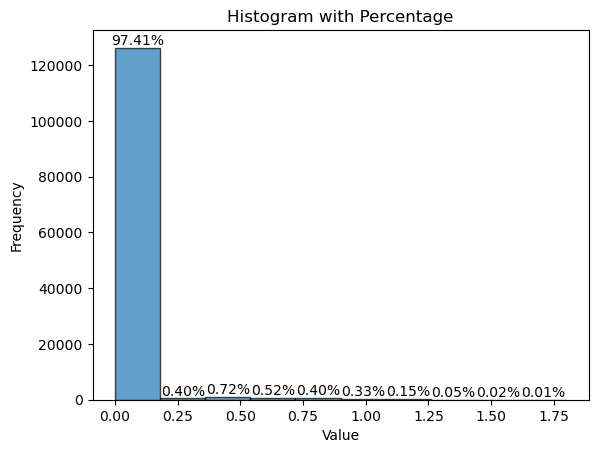

Mean SUV: 0.017320502357856142, Max SUV: 1.7984386115189261


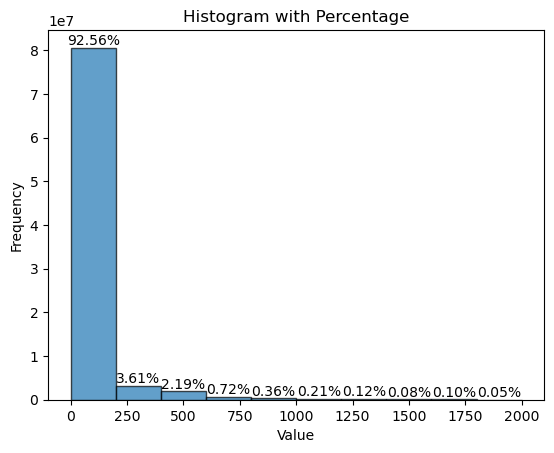

1935.0 397.97796951891667
data max: 1133, data min: 0


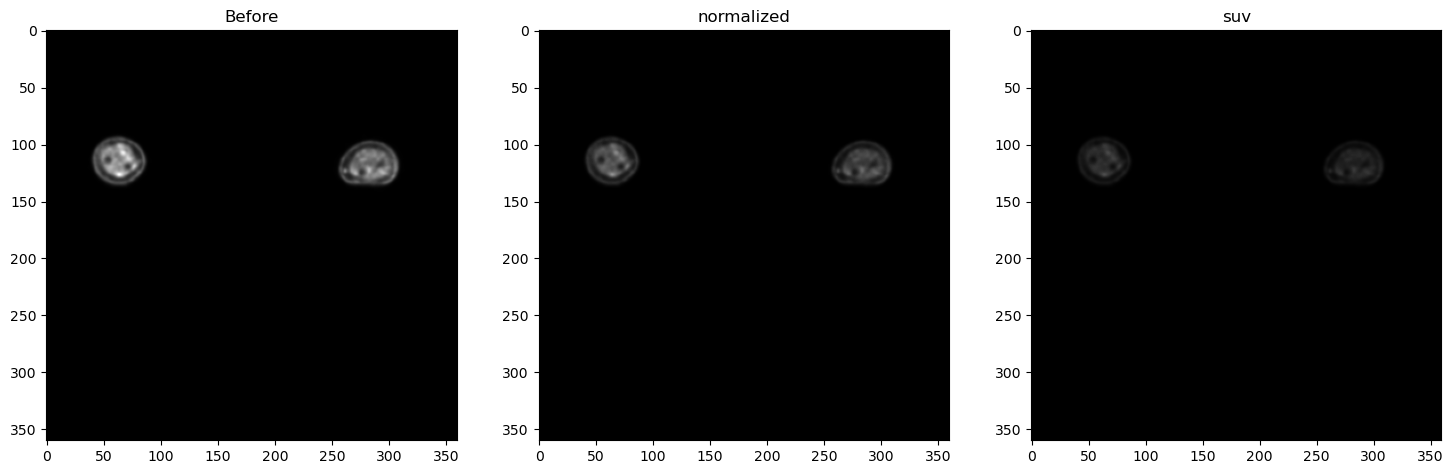

In [188]:
uExplorer_dir = "uExplorer/1st_uExplorer"
file_name = "Anonymous_ANO_20220224_1824561_122859/2.886 x 600 WB NORMAL/00000063.dcm"
full_file_name = os.path.join(dataset_dir, uExplorer_dir, file_name)
ds = pydicom.dcmread(full_file_name)
for elem in ds:
    print(elem)
print(ds.pixel_array)
ds.pixel_array.shape

suv = calSUV(ds)
viewData(suv)
print(f"Mean SUV: {np.mean(suv)}, Max SUV: {np.max(suv)}")
suv = normSUV(suv) * 255.0 / 6
pixel_array = ds.pixel_array
# if 'WindowWidth' in ds and 'WindowCenter' in ds:
#     print("WindowWidth and WindowCenter are defined.")
#     window_width = ds.WindowWidth
#     window_center = ds.WindowCenter
#     if isinstance(window_width, pydicom.valuerep.DSfloat):
#         window_width = [window_width]
#     if isinstance(window_center, pydicom.valuerep.DSfloat):
#         window_center = [window_center]
    
#     windowed_image = (pixel_array - (window_center[0] - window_width[0] / 2)) / window_width[0] * 255.0
#     windowed_image = np.clip(windowed_image, 0, 255).astype(np.uint16)
# else:
#     windowed_image = pixel_array
dataVolume = loadPETValue(os.path.join(dataset_dir, uExplorer_dir, "Anonymous_ANO_20220224_1824561_122859/2.886 x 600 WB NORMAL"))
threshold = viewData(dataVolume)
scaleFactor = calScaleFactor(dataVolume)
print(threshold, scaleFactor)
windowed_image = (pixel_array) / (scaleFactor * 5) * 255.0
windowed_image = np.clip(windowed_image, 0, 255).astype(np.uint16)

normalized_image = MaxMinNormalizer(pixel_array)
original_image = pixel_array*255.0/ds.WindowWidth

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(original_image, cmap="gray")
plt.title('Before')
plt.subplot(1,3,2)
plt.imshow(windowed_image, cmap="gray", vmin=0, vmax=255)
plt.title('normalized')
plt.subplot(1,3,3)
plt.imshow(suv, cmap="gray", vmin=0, vmax=255)
plt.title('suv')
plt.show()

2225.6986283117612 445.13972566235225
Mean SUV: 0.08395532657084942, Max SUV: 30.7807694832787


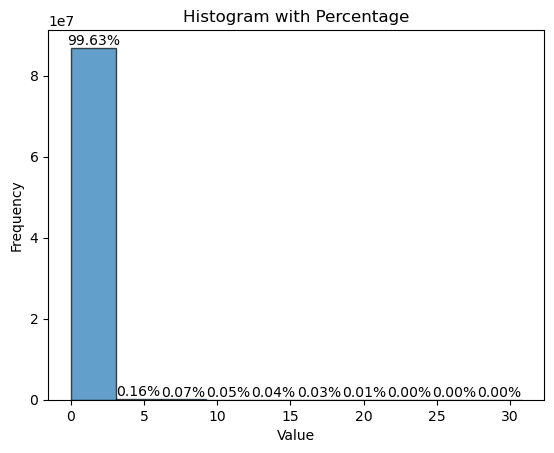

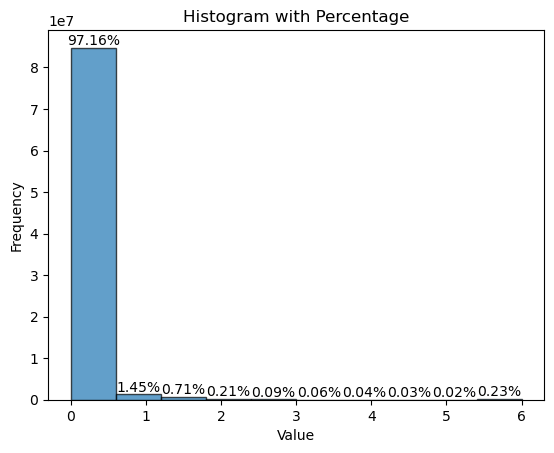

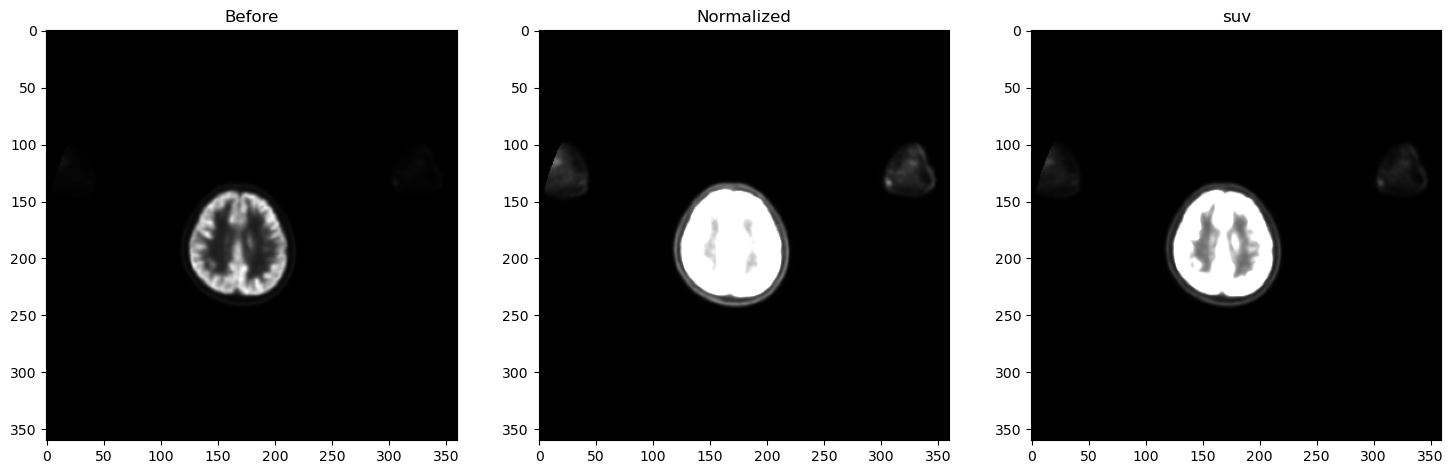

In [189]:
uExplorer_dir = "uExplorer/1st_uExplorer"
directory_name = "Anonymous_ANO_20220224_1826572_121743/2.886 x 600 WB NORMAL"
file_index = 77 # start from 1

dataVolume = loadPETValue(os.path.join(dataset_dir, uExplorer_dir, directory_name))
scaleFactor = calScaleFactor(dataVolume)
print(scaleFactor * 5, scaleFactor)
pixel_array = dataVolume[file_index-1]
windowed_image = (pixel_array) / min(scaleFactor * 5, np.max(dataVolume)) * 255.0
windowed_image = np.clip(windowed_image, 0, 255).astype(np.uint16)

# normalized_image = MaxMinNormalizer(pixel_array)
suvVolume = calSUVVolume(os.path.join(dataset_dir, uExplorer_dir, directory_name))
print(f"Mean SUV: {np.mean(suvVolume)}, Max SUV: {np.max(suvVolume)}")
data = normSUV(suvVolume, threshold=6) 
viewData(suvVolume)
viewData(data)
data = data * 255.0 / 6
suv_image = data[file_index-1]
original_image = pixel_array*255.0/ds.WindowWidth

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(original_image, cmap="gray")
plt.title('Before')
plt.subplot(1,3,2)
plt.imshow(windowed_image, cmap="gray", vmin=0, vmax=255)
plt.title('Normalized')
plt.subplot(1,3,3)
plt.imshow(suv_image, cmap="gray", vmin=0, vmax=255)
plt.title('suv')
plt.show()

In [222]:
import matplotlib.image as mpimg
from PIL import Image

def transfer_png_anonymous_dir(directory, dose_req = "NORMAL", NORMALIZE = False, SUV = False, suvThreshold = 6.0):
    """
    Count the number of files in directories that start with 'Anonymous_' in the given directory.

    :param directory: Path to the directory to search in.
    :param dose_req: Dose to transfer to PNG.
    :param NORMALIZE: Normalize the image using scaler or calculate the suv
    :return: Whether transfer succfully.
    """
    directory_name = directory.split("/")[-1]

    if directory_name.startswith('Anonymous_'):
        for folder_name in os.listdir(directory):
            dose_type = folder_name.split(" ")[-1]
            if dose_type == dose_req:
                if NORMALIZE:
                    data = loadPETValue(os.path.join(directory, folder_name))
                    scaleFactor = calScaleFactor(data)
                    data = data * 255.0 / (scaleFactor * 5)
                    print(f"Mean: {scaleFactor}, scaleFactor:{scaleFactor * 10}")  

                elif SUV:
                    data = calSUVVolume(os.path.join(directory, folder_name))
                    print(f"Mean SUV: {np.mean(data)}, Max SUV: {np.max(data)}")
                    data = normSUV(data, threshold=suvThreshold)    
                    data = data * 255.0 / suvThreshold
                    
                for i in range(1,len(data)+1,1):  
                    saved_image = data[i-1]                                                         
                    saved_folder = os.path.join(dataset_dir,"uExplorer", "pngImage", dose_type)
                    if not os.path.exists(saved_folder):
                        os.makedirs(saved_folder )
                    saved_name = dose_type+"_"+ directory_name+"_"+str(i)+".png"         
                    #plt.imsave(os.path.join(saved_folder,saved_name), saved_image, cmap='gray', vmin=0, vmax=255)           
                    mpimg.imsave(os.path.join(saved_folder,saved_name), saved_image, cmap="gray", vmin=0, vmax=255)
                    # saved_image = Image.fromarray(saved_image.astype(np.uint8))
                    # saved_image.save(os.path.join(saved_folder,saved_name))
                    # with open(os.path.join(saved_folder, saved_name), 'wb') as f:
                    #     saved_image.save(f, format='PNG')           
        return True
    return False

In [223]:
transfer_number = 14
dose_req = "NORMAL"
NORMALIZE = False
SUV = True
suvThreshold = 6.0

dose_list = ["NORMAL", "D2", "D4", "D10", "D20", "D50", "D100"]
err_results = []
err_cnt = 0
tot_cnt = 0
for folder_name in sorted(os.listdir(os.path.join(dataset_dir, uExplorer_dir))):
    print('Dose: {}, Transfer {} to png...'.format(dose_req, folder_name))
    folder_path = os.path.join(dataset_dir, uExplorer_dir, folder_name)
    result = transfer_png_anonymous_dir(folder_path, dose_req, NORMALIZE = NORMALIZE, SUV = SUV, suvThreshold = suvThreshold)
    tot_cnt+=1
    if not result:
        err_results.append(tot_cnt)
        err_cnt+=1
    if tot_cnt >= transfer_number:
        break
print("Successfully transfer {} to png.".format(tot_cnt))
if err_cnt != 0:
    print("Failed to transfer {} to png. Failed number: {}".format(err_cnt, err_results))
    

Dose: NORMAL, Transfer Anonymous_ANO_20220224_1824561_122859 to png...
Mean SUV: 0.07945600950607208, Max SUV: 25.12417152967481
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1826572_121743 to png...
Mean SUV: 0.08395532657084942, Max SUV: 30.7807694832787
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1828586_120633 to png...
Mean SUV: 0.07793909246194254, Max SUV: 68.83120579537432
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1831028_115350 to png...
Mean SUV: 0.08978188019708505, Max SUV: 383.04349932770424
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1833020_114003 to png...
Mean SUV: 0.09571798984195257, Max SUV: 17.858653430124882
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1835039_111917 to png...
Mean SUV: 0.045695574750436396, Max SUV: 358.08200342368417
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1837073_110801 to png...
Mean SUV: 0.04287161449998605, Max SUV: 63.55741439118472
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1839044_105624 to png...
Mean SUV: 0.05759726051